In [1]:
import operator
import math

In [5]:
def createDataSet():
    dataSet = [[1, 1, 'yes'],
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    # 熵越高，表明混合的数据越多
#     dataSet = [[1, 1, 'a'],
#                [1, 1, 'b'],
#                [1, 0, 'c'],
#                [0, 1, 'd'],
#                [0, 1, 'no']]
    labels = ['no surfacing','flippers']
    return dataSet, labels


def calcShannonEnt(dataSet):
    numEntries = len(dataSet)
    labelCounts = {}
    # 计算类别出现的次数
    for featVec in dataSet: 
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
    shannonEnt = 0.0
    for key in labelCounts:
        # 以出现的频率作为概率，计算信息熵
        prob = float(labelCounts[key])/numEntries
        shannonEnt -= prob * math.log(prob,2) 
    return shannonEnt

data, label = createDataSet()
xn = calcShannonEnt(data)
print(xn)

0.9709505944546686


In [10]:
# 利用信息熵带来的变化，来寻找最优的来划分数据集方案
def splitDataSet(dataSet, axis, value):
    retDataSet = []
    for featVec in dataSet:
        # 对data去除指定axis的特征值，并返回data
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]     
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet


def chooseBestFeatureToSplit(dataSet):
    numFeatures = len(dataSet[0]) - 1      #the last column is used for the labels
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0; bestFeature = -1
    for i in range(numFeatures):        #iterate over all the features
        featList = [example[i] for example in dataSet]#create a list of all the examples of this feature
        uniqueVals = set(featList)       #get a set of unique values
        newEntropy = 0.0
        for value in uniqueVals:
            subDataSet = splitDataSet(dataSet, i, value)
            prob = len(subDataSet)/float(len(dataSet))
            newEntropy += prob * calcShannonEnt(subDataSet)
        infoGain = baseEntropy - newEntropy     #calculate the info gain; ie reduction in entropy
        if (infoGain > bestInfoGain):       #compare this to the best gain so far
            bestInfoGain = infoGain         #if better than current best, set to best
            bestFeature = i
    return bestFeature

best_id = chooseBestFeatureToSplit(data)
print(best_id)

0


In [11]:
# 创建决策树
def majorityCnt(classList):
    classCount={}
    for vote in classList:
        if vote not in classCount.keys(): classCount[vote] = 0
        classCount[vote] += 1
    sortedClassCount = sorted(classCount.iteritems(), key=operator.itemgetter(1), reverse=True)
    return sortedClassCount[0][0]


def createTree(dataSet,labels):
    classList = [example[-1] for example in dataSet]
    # 中止分支第一个判断条件
    # 是否所有数据实例都是相同类型，如果是，则停止此分支的划分
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    # 中止分支的第二个判断条件
    # 当最终，还没有出现子集中的实例属于同一类型的情况时，采用出现次数最多的类别作为返回值
    if len(dataSet[0]) == 1: 
        return majorityCnt(classList)
    bestFeat = chooseBestFeatureToSplit(dataSet)
    bestFeatLabel = labels[bestFeat]
    myTree = {bestFeatLabel:{}}
    del(labels[bestFeat])
    featValues = [example[bestFeat] for example in dataSet]
    uniqueVals = set(featValues)
    for value in uniqueVals:
        subLabels = labels[:]   
        myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value),subLabels)
    return myTree

data, label = createDataSet()
out = createTree(data, label)
print(out)

{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}


In [6]:
# 对新的data进行预测分类
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstStr)
    key = testVec[featIndex]
    # 从第一个节点出发，依次检测分支特征对应值是否结束节点
    valueOfFeat = secondDict[key]
    # 检测的依据是特征键对应值是否为字典，如果为字典说明还存在子分支，说明依据该特征暂时还不能给出具体类别
    # 进一步，再对下面的分支，也就是第二个特征进行检测，直到遇到中止节点才结束
    if isinstance(valueOfFeat, dict):
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else:
        classLabel = valueOfFeat
    return classLabel

def retrieveTree(i):
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

data, labels = createDataSet()
out = retrieveTree(0)
# 检测data为[0, 1]
# 依据第一个特征值0，就能断定所属类别
# 从tree或者训练data都可以推断出输出'no'是正确的
a = classify(out, labels, [0, 1])
print(a)

no


In [12]:
# 预测隐形眼镜类型
f = open('lenses.txt', 'r')
lenses_data = []
for line in f.readlines():
    data = line.strip().split('\t')
    lenses_data.append(data)
lenses_labels = ['age',  'prescript', 'astigmatic', 'tearRate']
lenses_trees = createTree(lenses_data, lenses_labels)
print(lenses_trees)

{'tearRate': {'reduced': 'no lenses', 'normal': {'astigmatic': {'no': {'age': {'young': 'soft', 'presbyopic': {'prescript': {'myope': 'no lenses', 'hyper': 'soft'}}, 'pre': 'soft'}}, 'yes': {'prescript': {'myope': 'hard', 'hyper': {'age': {'young': 'hard', 'presbyopic': 'no lenses', 'pre': 'no lenses'}}}}}}}}


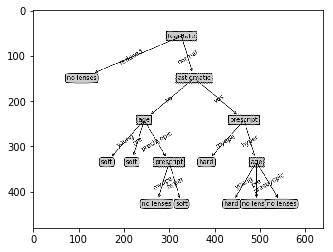

In [21]:
# 树可视化，代码没看~~
import matplotlib.pyplot as plt
from PIL import Image
img = Image.open('tree_plot.png')
plt.imshow(img)
plt.show()

此决策树算法成为ID3，仅适用于划分标称型数据集，通常也会遇到过度匹配(过拟合)的问题。